## Dataset

Let's consider the MNIST and SVHN datasets to implement our joint VAE. These datasets can be directly downloaded from the Pytorch vision package.

In [42]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for MNIST to resize to 32x32
mnist_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# Load MNIST dataset
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_loader = DataLoader(mnist_data, batch_size=64, shuffle=True)

# Load SVHN dataset
svhn_data = datasets.SVHN(root='./data/SVHN', split='train', download=True, transform=transforms.ToTensor())
svhn_loader = DataLoader(svhn_data, batch_size=64, shuffle=True)


Using downloaded and verified file: ./data/SVHN\train_32x32.mat


Showing 64 samples out of 60000 for: MNIST Samples


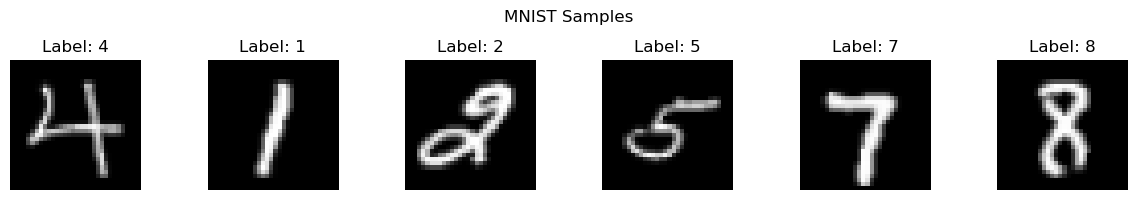

Showing 64 samples out of 73257 for: SVHN Samples


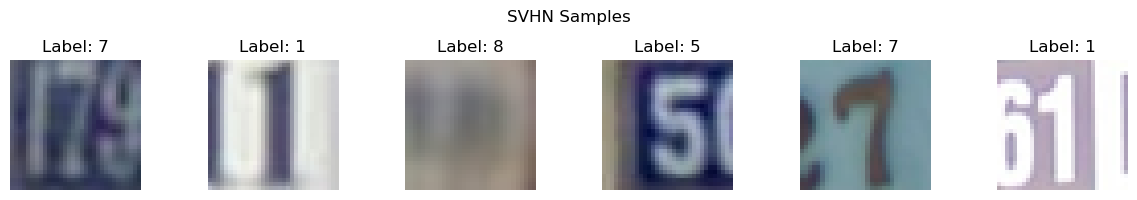

In [43]:
# Visualize some samples from both datasets
import matplotlib.pyplot as plt

def show_samples(data_loader, title):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(1, 6, figsize=(12, 2))
    for i in range(6):
        if images.shape[1] == 1:  # Grayscale image (MNIST)
            axes[i].imshow(images[i].squeeze(), cmap='gray')
        else:  # Color image (SVHN)
            axes[i].imshow(images[i].permute(1, 2, 0))
        axes[i].set_title(f'Label: {labels[i]}')
        axes[i].axis('off')
    num_samples = images.shape[0]
    print(f"Showing {num_samples} samples out of {len(data_loader.dataset)} for: {title}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(mnist_loader, 'MNIST Samples')
show_samples(svhn_loader, 'SVHN Samples')

Now that we have defined our datasets, we can proceed to implement the joint VAE architecture and training procedure. First, let us ensure our **joint** database is correctly set up. That is, for each MNIST image, we need to have a corresponding SVHN image with the same label (digit). This can be achieved by filtering and pairing the datasets based on their labels.

In [44]:
# Filter and pair datasets based on labels
import numpy as np

# Get all labels
mnist_labels = mnist_data.targets.numpy()
svhn_labels = svhn_data.labels

# Create dictionaries mapping labels to indices
mnist_label_to_indices = {label: [] for label in range(10)}
svhn_label_to_indices = {label: [] for label in range(10)}

# Populate the dictionaries
for i, label in enumerate(mnist_labels):
    mnist_label_to_indices[label].append(i)

for i, label in enumerate(svhn_labels):
    svhn_label_to_indices[label].append(i)

paired_mnist_indices = []
paired_svhn_indices = []

# Pair samples with the same label
for label in range(10):
    mnist_indices = mnist_label_to_indices[label]
    svhn_indices = svhn_label_to_indices[label]

    # Pair up to min count
    min_count = min(len(mnist_indices), len(svhn_indices))
    paired_mnist_indices.extend(mnist_indices[:min_count])
    paired_svhn_indices.extend(svhn_indices[:min_count])

print(f"MNIST samples: {len(mnist_labels)}")
print(f"SVHN samples: {len(svhn_labels)}")
print(f"Paired samples: {len(paired_mnist_indices)}")

# Create paired loaders using indices
class PairedDataset:
    def __init__(self, dataset1, dataset2, indices1, indices2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.indices1 = indices1
        self.indices2 = indices2
    
    def __len__(self):
        return len(self.indices1)
    
    def __getitem__(self, idx):
        img1, label1 = self.dataset1[self.indices1[idx]]
        img2, label2 = self.dataset2[self.indices2[idx]]
        return img1, img2, label1, label2

paired_dataset = PairedDataset(mnist_data, svhn_data, paired_mnist_indices, paired_svhn_indices)
paired_loader = DataLoader(paired_dataset, batch_size=64, shuffle=True)

# Updated visualization
def show_paired_samples(loader):
    images1, images2, labels1, labels2 = next(iter(loader))
    
    fig, axes = plt.subplots(2, 6, figsize=(12, 4))
    for i in range(6):
        axes[0, i].imshow(images1[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f'MNIST: {labels1[i]}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(images2[i].permute(1, 2, 0))
        axes[1, i].set_title(f'SVHN: {labels2[i]}')
        axes[1, i].axis('off')
    
    plt.suptitle('Paired MNIST and SVHN Samples')
    plt.tight_layout()
    plt.show()

MNIST samples: 60000
SVHN samples: 73257
Paired samples: 56068


We have created a `PairedDataset` class that takes two datasets and pairs samples with matching labels. Note that only 56068 pairs were formed since both datasets do not have the same number of samples for each digit. The number of paired samples has an upper bound defined by:

$$\text{Number of pairs} \leq \min(\text{\# MNIST samples}, \text{\# SVHN samples})$$

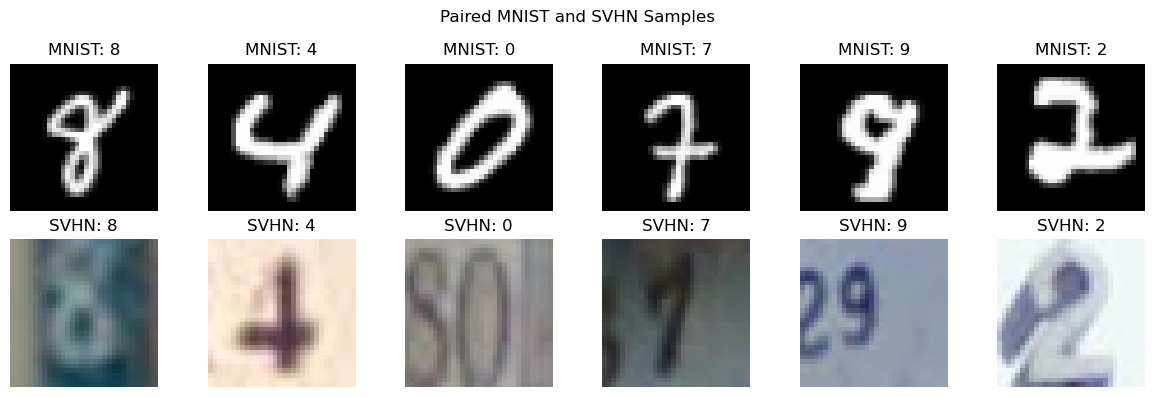

In [45]:
show_paired_samples(paired_loader)

## Multi-View VAE Implementation

Now that we have our paired dataset, we can proceed to implement the multi-view VAE architecture. The joint VAE will consist of separate encoders and decoders for each view (MNIST and SVHN) but will share a common latent space.

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Helper functions for reparameterization and Product of Experts
def reparameterize(mu, logvar):
    """
    Reparameterization trick: z = mu + std * epsilon
    """
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

def product_of_experts(mu1, logvar1, mu2, logvar2):
    """
    Combines two Gaussian experts using Product of Experts.
    Returns the parameters (mu, logvar) of the joint distribution.
    Assumes diagonal covariance matrices.
    """
    var1 = torch.exp(logvar1)
    var2 = torch.exp(logvar2)

    # Precision is inverse variance
    precision1 = 1.0 / var1
    precision2 = 1.0 / var2

    # Joint precision is sum of precisions
    joint_precision = precision1 + precision2

    # Joint variance is inverse of joint precision
    joint_var = 1.0 / joint_precision

    # Joint mean is precision-weighted sum of means
    joint_mu = (mu1 * precision1 + mu2 * precision2) * joint_var

    # Joint log variance
    joint_logvar = torch.log(joint_var)

    return joint_mu, joint_logvar

# Encoder architecture(s) using simple CNNs
class MNISTEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(MNISTEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)   
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) 
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    # Forward pass
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class SVHNEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(SVHNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)   
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) 
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    # Forward pass
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Decoder architecture(s) using simple CNNs
class MNISTDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(MNISTDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 64 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)  
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)   
        self.deconv3 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)   
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(16)

    # Forward pass
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = z.view(z.size(0), 64, 4, 4)
        z = F.relu(self.bn1(self.deconv1(z)))
        z = F.relu(self.bn2(self.deconv2(z)))
        x_recon = torch.sigmoid(self.deconv3(z))
        return x_recon

class SVHNDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(SVHNDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 64 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1) 
        self.deconv3 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)    
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(16)

    # Forward pass
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = z.view(z.size(0), 64, 4, 4)
        z = F.relu(self.bn1(self.deconv1(z)))
        z = F.relu(self.bn2(self.deconv2(z)))
        x_recon = torch.sigmoid(self.deconv3(z))
        return x_recon

Now that we have defined our helper functions and encoder/decoder architectures, we can proceed to implement the training loop for our multi-view VAE. The training process involves optimizing the combined loss function that includes reconstruction losses for both views and the KL divergence term.

In [58]:
# Multi-View VAE Model
class MultiViewVAE(nn.Module):
    def __init__(self, latent_dim):
        super(MultiViewVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder_mnist = MNISTEncoder(latent_dim)
        self.encoder_svhn = SVHNEncoder(latent_dim)
        self.decoder_mnist = MNISTDecoder(latent_dim)
        self.decoder_svhn = SVHNDecoder(latent_dim)

    # Forward pass
    def forward(self, x_mnist, x_svhn):
        # Encode each modality
        mu_mnist, logvar_mnist = self.encoder_mnist(x_mnist)
        mu_svhn, logvar_svhn = self.encoder_svhn(x_svhn)

        # Combine using Product of Experts to get joint posterior parameters
        mu_joint, logvar_joint = product_of_experts(
            mu_mnist, logvar_mnist, mu_svhn, logvar_svhn
        )

        # Sample from the joint posterior using reparameterization trick
        z_joint = reparameterize(mu_joint, logvar_joint)

        # Decode using the joint latent variable
        x_recon_mnist = self.decoder_mnist(z_joint)
        x_recon_svhn = self.decoder_svhn(z_joint)

        return (
            x_recon_mnist,
            x_recon_svhn,
            mu_joint,
            logvar_joint,
            mu_mnist,
            logvar_mnist, 
            mu_svhn,
            logvar_svhn,
        )

    def generate(self, z):
        """Generate samples from latent variable z"""
        self.eval()  # Put model in evaluation mode
        with torch.no_grad():
            x_gen_mnist = self.decoder_mnist(z)
            x_gen_svhn = self.decoder_svhn(z)
        return x_gen_mnist, x_gen_svhn

    def reconstruct_cross(self, x_mnist=None, x_svhn=None):
        """Reconstruct one modality given the other"""
        self.eval()
        with torch.no_grad():
            if x_mnist is not None and x_svhn is None:
                # Use MNIST encoder to get latent z, then decode with SVHN decoder
                mu, logvar = self.encoder_mnist(x_mnist)
                z = reparameterize(mu, logvar)  # Could also just use mu
                x_cross_svhn = self.decoder_svhn(z)
                x_recon_mnist = self.decoder_mnist(z)  # Also reconstruct original
                return x_recon_mnist, x_cross_svhn
            elif x_svhn is not None and x_mnist is None:
                # Use SVHN encoder to get latent z, then decode with MNIST decoder
                mu, logvar = self.encoder_svhn(x_svhn)
                z = reparameterize(mu, logvar)  # Could also just use mu
                x_cross_mnist = self.decoder_mnist(z)
                x_recon_svhn = self.decoder_svhn(z)  # Also reconstruct original
                return x_cross_mnist, x_recon_svhn
            else:
                raise ValueError(
                    "Provide exactly one input modality (x_mnist or x_svhn)"
                )

We now define the loss function for the multi-view VAE. The loss consists of three components: the reconstruction loss for the MNIST view, the reconstruction loss for the SVHN view, and the KL divergence loss that regularizes the latent space.

In [72]:
def vae_loss(
    x_recon_mnist, x_mnist, x_recon_svhn, x_svhn, mu_joint, logvar_joint, beta=5
):
    """
    Computes the VAE loss (Evidence Lower Bound - ELBO).
    Uses Binary Cross-Entropy (BCE) for reconstruction.
    Assumes inputs x_mnist, x_svhn are scaled to [0, 1].
    """
    # Reconstruction Loss (summed over pixels and batch)
    # Using BCE loss assuming inputs are normalized [0,1] and decoder output is sigmoid
    recon_loss_mnist = F.binary_cross_entropy(
    x_recon_mnist.reshape(x_mnist.size(0), -1),
    x_mnist.reshape(x_mnist.size(0), -1),
    reduction="sum",
)

    recon_loss_svhn = F.binary_cross_entropy(
    x_recon_svhn.reshape(x_svhn.size(0), -1),
    x_svhn.reshape(x_svhn.size(0), -1),
    reduction="sum",
)

    # KL Divergence between joint posterior q(z|x1,x2) and prior p(z)=N(0,I)
    # 0.5 * sum(mu^2 + sigma^2 - 1 - log(sigma^2))
    kl_div = 0.5 * torch.sum(mu_joint.pow(2) + torch.exp(logvar_joint) - 1 - logvar_joint)

    # Total Loss (negative ELBO) - averaged over batch size
    batch_size = x_mnist.size(0)
    total_loss = (recon_loss_mnist + recon_loss_svhn + beta * kl_div) / batch_size

    return (
        total_loss,
        recon_loss_mnist / batch_size,
        recon_loss_svhn / batch_size,
        kl_div / batch_size,
    )

Everything is now set up to train our multi-view VAE on the paired MNIST and SVHN datasets. We will train the model for a specified number of epochs, monitoring the loss to ensure that the model is learning effectively.

Train Epoch: 0 [0/56068 (0%)]	Loss: 3266.898926 ReconM: 1059.6714 ReconS: 2199.8708 KLD: 1.4714
Train Epoch: 0 [6400/56068 (11%)]	Loss: 2392.773682 ReconM: 397.5370 ReconS: 1980.8503 KLD: 2.8772
Train Epoch: 0 [12800/56068 (23%)]	Loss: 2306.016846 ReconM: 296.5662 ReconS: 1997.4113 KLD: 2.4079
Train Epoch: 0 [19200/56068 (34%)]	Loss: 2236.624268 ReconM: 280.2692 ReconS: 1936.2131 KLD: 4.0284
Train Epoch: 0 [25600/56068 (46%)]	Loss: 2247.857666 ReconM: 256.7865 ReconS: 1967.5309 KLD: 4.7081
Train Epoch: 0 [32000/56068 (57%)]	Loss: 2263.608154 ReconM: 246.8151 ReconS: 1985.3313 KLD: 6.2923
Train Epoch: 0 [38400/56068 (68%)]	Loss: 2248.614746 ReconM: 237.6968 ReconS: 1978.4497 KLD: 6.4936
Train Epoch: 0 [44800/56068 (80%)]	Loss: 2228.760498 ReconM: 222.5623 ReconS: 1970.2557 KLD: 7.1885
Train Epoch: 0 [51200/56068 (91%)]	Loss: 2238.811279 ReconM: 219.1371 ReconS: 1983.1255 KLD: 7.3098
====> Epoch: 0 Average loss: 2291.1334


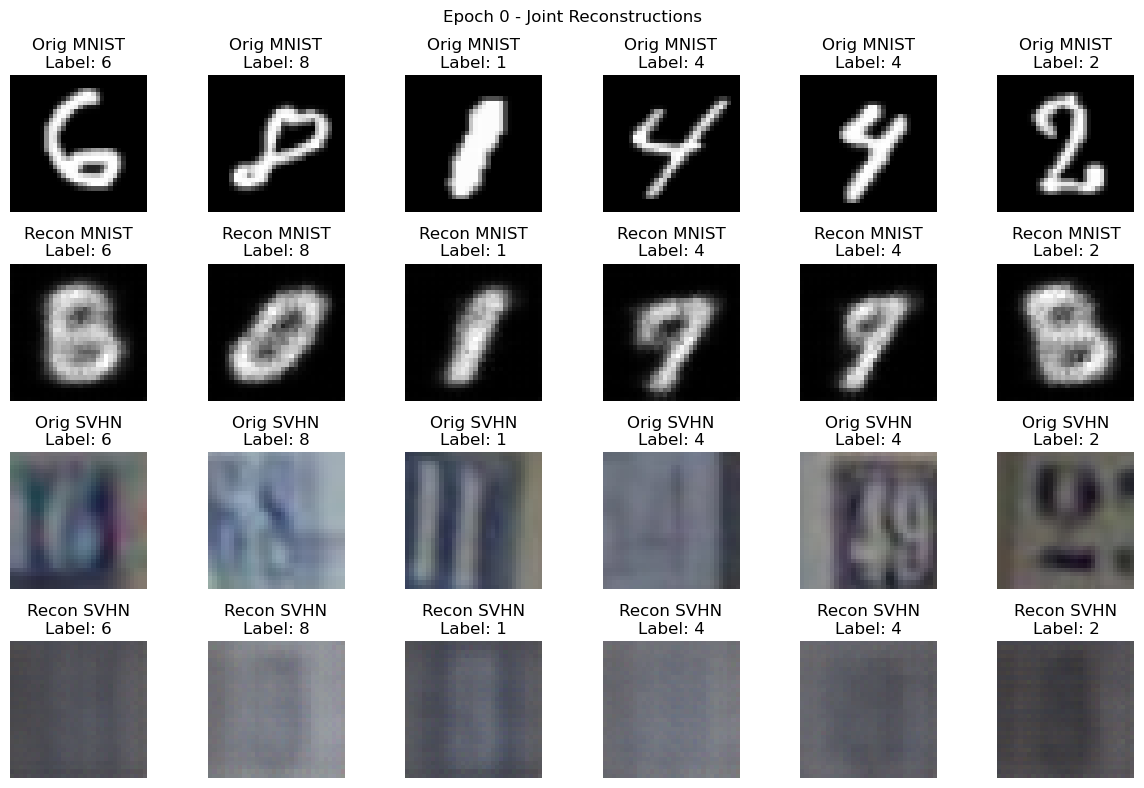

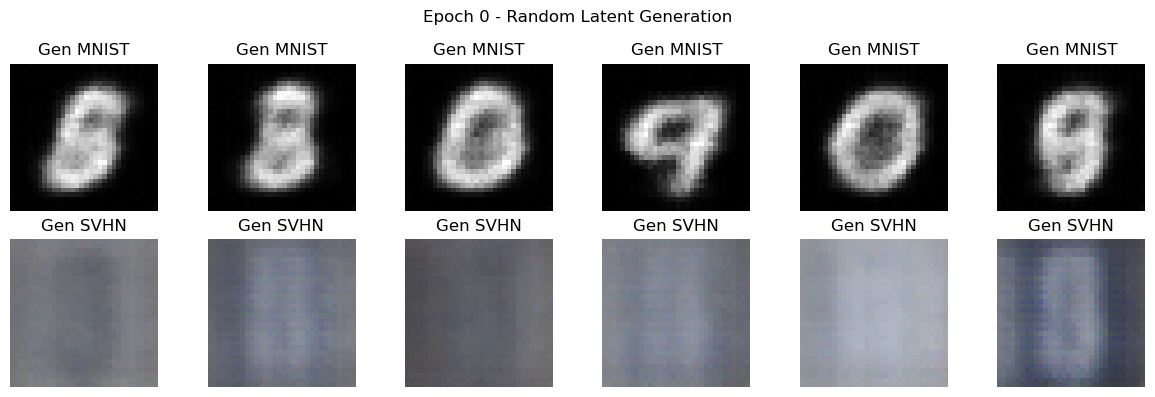

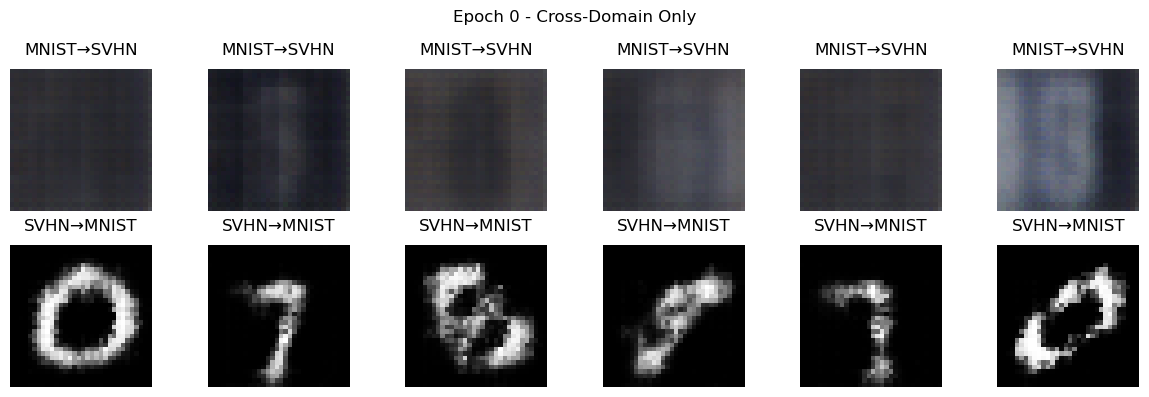

Train Epoch: 1 [0/56068 (0%)]	Loss: 2177.256836 ReconM: 210.6479 ReconS: 1932.2152 KLD: 6.8788
Train Epoch: 1 [6400/56068 (11%)]	Loss: 2237.255615 ReconM: 212.5502 ReconS: 1986.0771 KLD: 7.7256
Train Epoch: 1 [12800/56068 (23%)]	Loss: 2182.875000 ReconM: 214.2397 ReconS: 1930.1405 KLD: 7.6990
Train Epoch: 1 [19200/56068 (34%)]	Loss: 2194.044922 ReconM: 199.8014 ReconS: 1953.2163 KLD: 8.2055
Train Epoch: 1 [25600/56068 (46%)]	Loss: 2168.639160 ReconM: 194.8323 ReconS: 1934.2180 KLD: 7.9178
Train Epoch: 1 [32000/56068 (57%)]	Loss: 2172.488525 ReconM: 190.0161 ReconS: 1937.4966 KLD: 8.9952
Train Epoch: 1 [38400/56068 (68%)]	Loss: 2192.586670 ReconM: 190.8490 ReconS: 1960.3981 KLD: 8.2679
Train Epoch: 1 [44800/56068 (80%)]	Loss: 2161.257080 ReconM: 188.8900 ReconS: 1925.5072 KLD: 9.3720
Train Epoch: 1 [51200/56068 (91%)]	Loss: 2240.061768 ReconM: 192.3805 ReconS: 2002.0579 KLD: 9.1247
====> Epoch: 1 Average loss: 2192.8459
Train Epoch: 2 [0/56068 (0%)]	Loss: 2177.894531 ReconM: 193.9149 Re

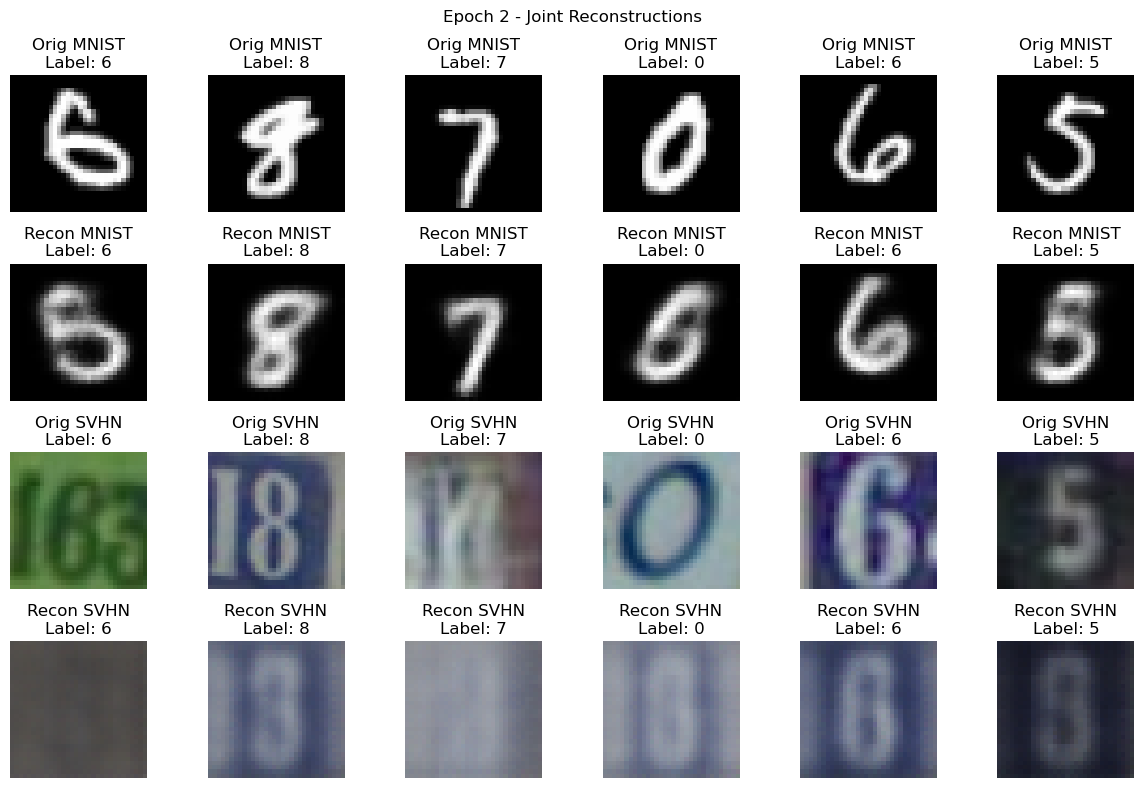

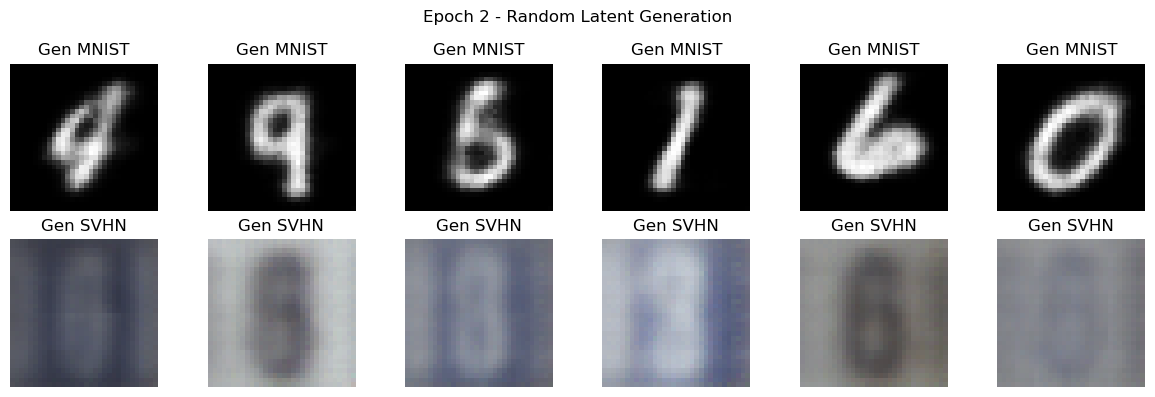

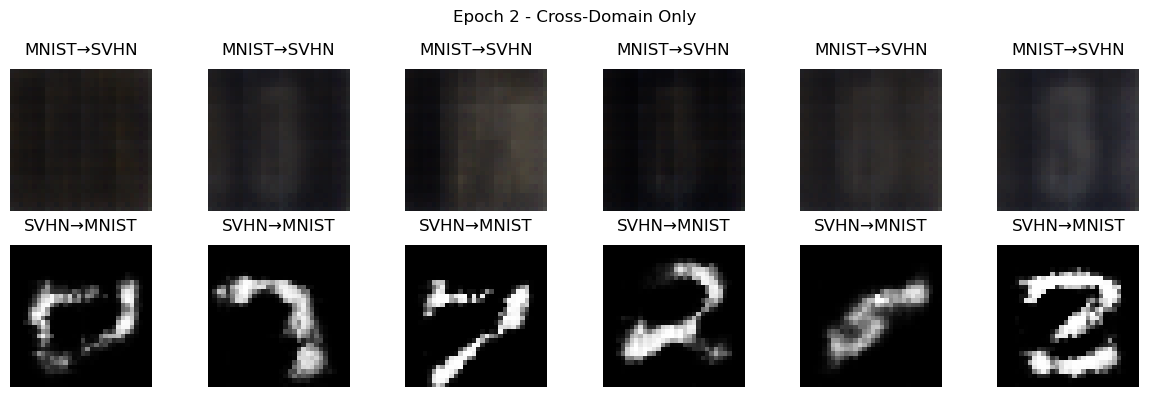

Train Epoch: 3 [0/56068 (0%)]	Loss: 2152.304688 ReconM: 183.8308 ReconS: 1919.6086 KLD: 9.7731
Train Epoch: 3 [6400/56068 (11%)]	Loss: 2189.731445 ReconM: 174.8761 ReconS: 1967.7106 KLD: 9.4290
Train Epoch: 3 [12800/56068 (23%)]	Loss: 2171.814697 ReconM: 186.3723 ReconS: 1937.7153 KLD: 9.5454
Train Epoch: 3 [19200/56068 (34%)]	Loss: 2210.451172 ReconM: 188.8385 ReconS: 1972.0579 KLD: 9.9109
Train Epoch: 3 [25600/56068 (46%)]	Loss: 2201.073975 ReconM: 171.3924 ReconS: 1980.7377 KLD: 9.7888
Train Epoch: 3 [32000/56068 (57%)]	Loss: 2180.130371 ReconM: 187.6843 ReconS: 1942.1378 KLD: 10.0616
Train Epoch: 3 [38400/56068 (68%)]	Loss: 2167.602051 ReconM: 183.2135 ReconS: 1937.5654 KLD: 9.3646
Train Epoch: 3 [44800/56068 (80%)]	Loss: 2193.044189 ReconM: 183.9550 ReconS: 1957.4371 KLD: 10.3304
Train Epoch: 3 [51200/56068 (91%)]	Loss: 2168.384521 ReconM: 178.5599 ReconS: 1939.8652 KLD: 9.9919
====> Epoch: 3 Average loss: 2174.3892
Train Epoch: 4 [0/56068 (0%)]	Loss: 2170.807617 ReconM: 187.8120 

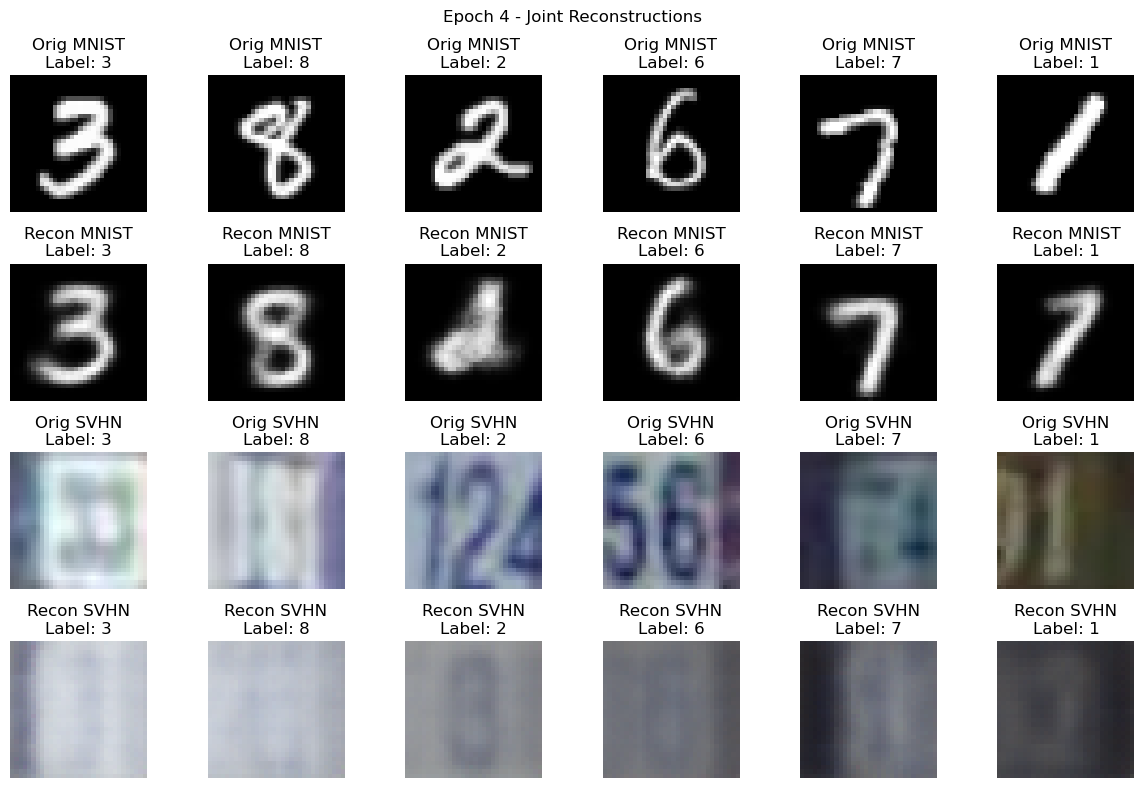

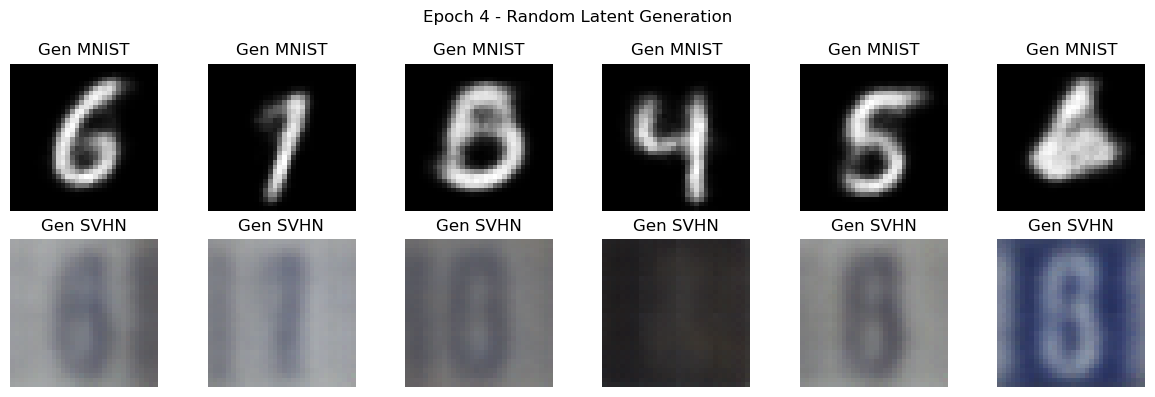

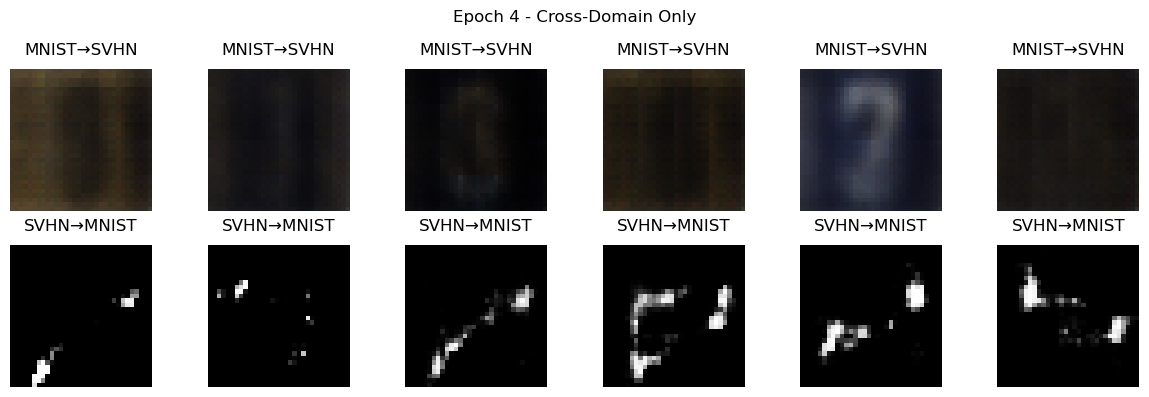

Train Epoch: 5 [0/56068 (0%)]	Loss: 2212.452881 ReconM: 204.2832 ReconS: 1954.7916 KLD: 10.6756
Train Epoch: 5 [6400/56068 (11%)]	Loss: 2167.426025 ReconM: 178.6091 ReconS: 1934.6787 KLD: 10.8276
Train Epoch: 5 [12800/56068 (23%)]	Loss: 2140.997559 ReconM: 169.5430 ReconS: 1917.1108 KLD: 10.8687
Train Epoch: 5 [19200/56068 (34%)]	Loss: 2155.917725 ReconM: 184.2106 ReconS: 1917.1100 KLD: 10.9194
Train Epoch: 5 [25600/56068 (46%)]	Loss: 2176.132568 ReconM: 179.5064 ReconS: 1942.8008 KLD: 10.7651
Train Epoch: 5 [32000/56068 (57%)]	Loss: 2157.957031 ReconM: 165.9751 ReconS: 1940.2637 KLD: 10.3436
Train Epoch: 5 [38400/56068 (68%)]	Loss: 2170.985107 ReconM: 179.3338 ReconS: 1936.9484 KLD: 10.9406
Train Epoch: 5 [44800/56068 (80%)]	Loss: 2144.740723 ReconM: 172.9882 ReconS: 1917.6980 KLD: 10.8109
Train Epoch: 5 [51200/56068 (91%)]	Loss: 2148.126953 ReconM: 173.3431 ReconS: 1923.2587 KLD: 10.3050
====> Epoch: 5 Average loss: 2167.9564
Train Epoch: 6 [0/56068 (0%)]	Loss: 2189.755615 ReconM: 18

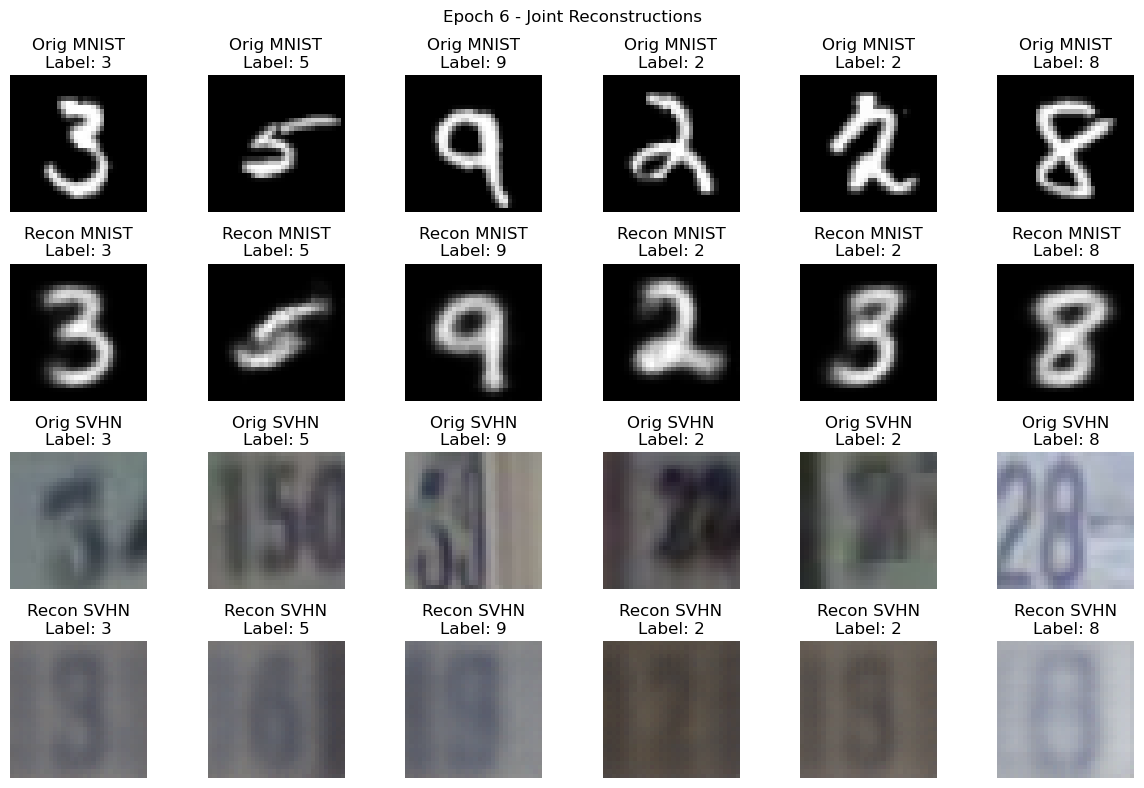

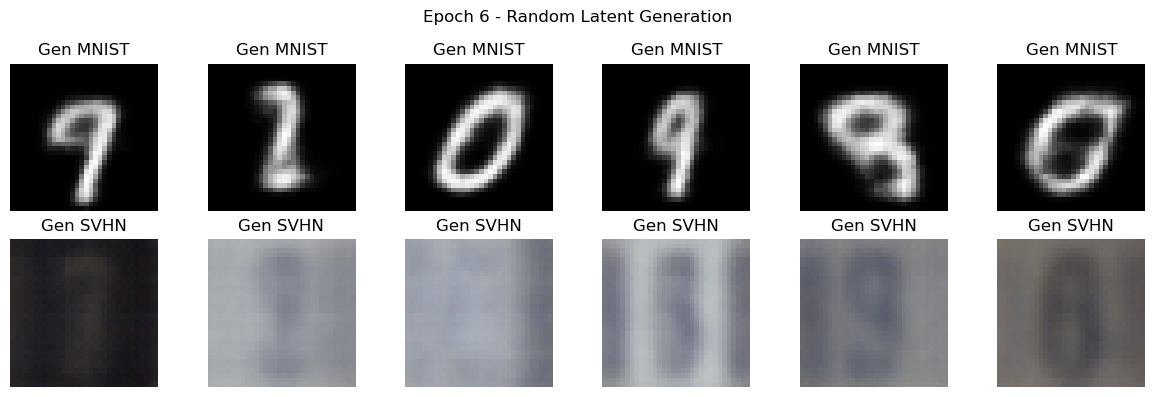

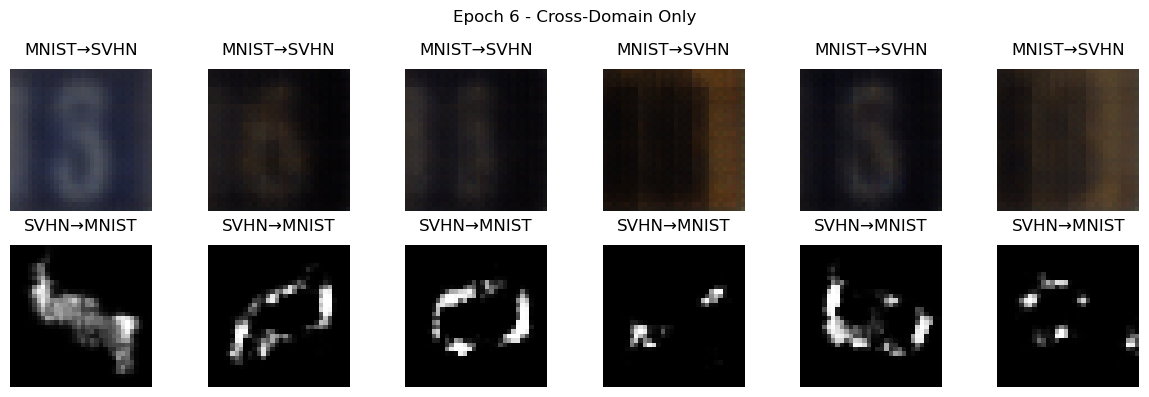

Train Epoch: 7 [0/56068 (0%)]	Loss: 2181.315918 ReconM: 162.8263 ReconS: 1963.9922 KLD: 10.8995
Train Epoch: 7 [6400/56068 (11%)]	Loss: 2152.555420 ReconM: 185.4055 ReconS: 1911.3743 KLD: 11.1551
Train Epoch: 7 [12800/56068 (23%)]	Loss: 2176.763184 ReconM: 167.3448 ReconS: 1955.8654 KLD: 10.7106
Train Epoch: 7 [19200/56068 (34%)]	Loss: 2142.932373 ReconM: 174.2428 ReconS: 1915.2168 KLD: 10.6946
Train Epoch: 7 [25600/56068 (46%)]	Loss: 2164.254883 ReconM: 167.5912 ReconS: 1941.5190 KLD: 11.0289
Train Epoch: 7 [32000/56068 (57%)]	Loss: 2163.759277 ReconM: 174.3397 ReconS: 1934.4619 KLD: 10.9915
Train Epoch: 7 [38400/56068 (68%)]	Loss: 2157.396240 ReconM: 167.9608 ReconS: 1934.4174 KLD: 11.0036
Train Epoch: 7 [44800/56068 (80%)]	Loss: 2136.249023 ReconM: 177.3727 ReconS: 1903.3794 KLD: 11.0993
Train Epoch: 7 [51200/56068 (91%)]	Loss: 2148.261719 ReconM: 181.8967 ReconS: 1910.4495 KLD: 11.1831
====> Epoch: 7 Average loss: 2164.6932
Train Epoch: 8 [0/56068 (0%)]	Loss: 2153.681396 ReconM: 17

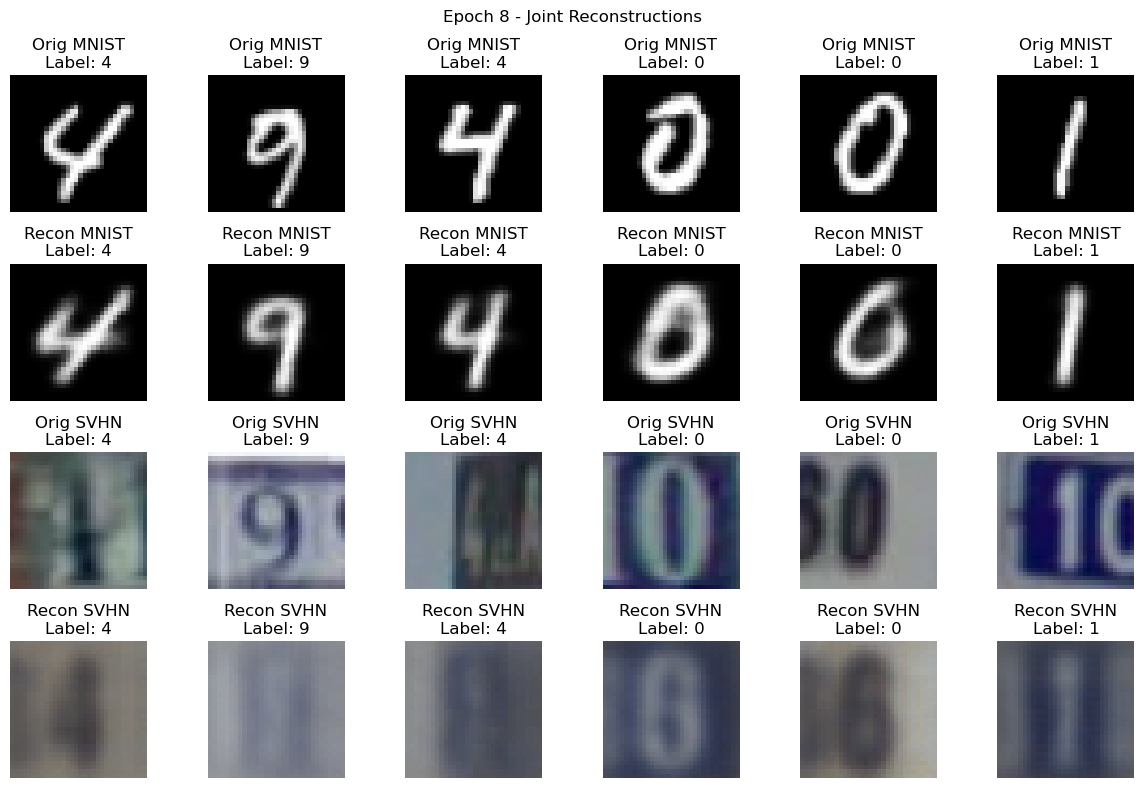

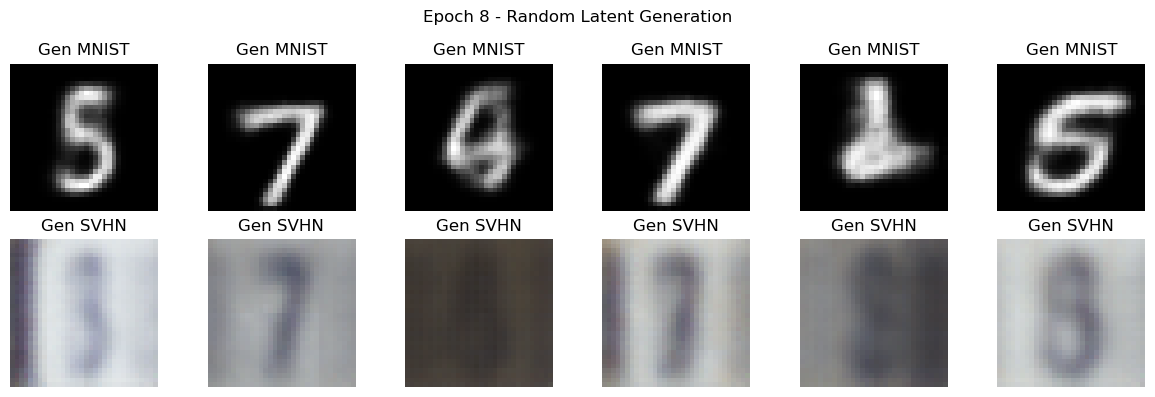

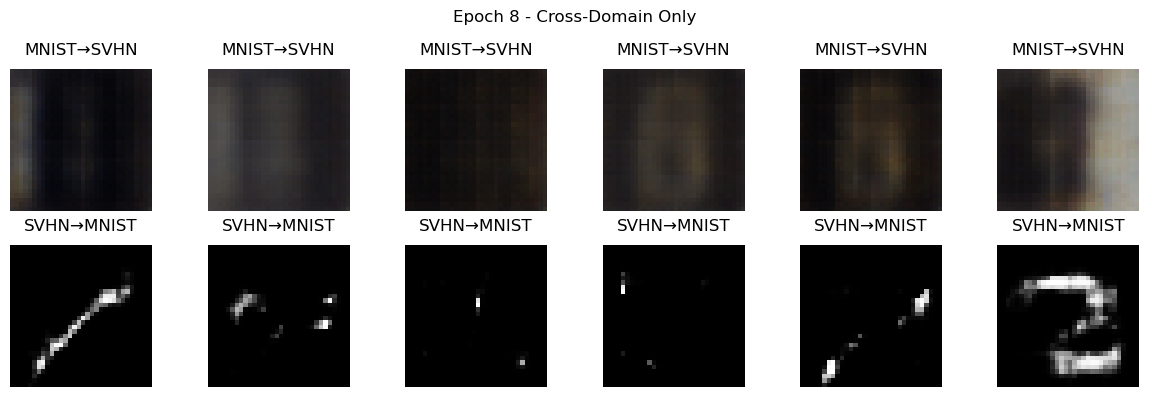

Train Epoch: 9 [0/56068 (0%)]	Loss: 2183.255371 ReconM: 177.4161 ReconS: 1949.0273 KLD: 11.3624
Train Epoch: 9 [6400/56068 (11%)]	Loss: 2166.544678 ReconM: 170.7265 ReconS: 1941.1464 KLD: 10.9344
Train Epoch: 9 [12800/56068 (23%)]	Loss: 2229.027344 ReconM: 183.3163 ReconS: 1990.4058 KLD: 11.0610
Train Epoch: 9 [19200/56068 (34%)]	Loss: 2115.027588 ReconM: 177.5643 ReconS: 1882.9053 KLD: 10.9116
Train Epoch: 9 [25600/56068 (46%)]	Loss: 2219.635986 ReconM: 173.2382 ReconS: 1989.9651 KLD: 11.2865
Train Epoch: 9 [32000/56068 (57%)]	Loss: 2175.390137 ReconM: 179.3386 ReconS: 1939.0719 KLD: 11.3960
Train Epoch: 9 [38400/56068 (68%)]	Loss: 2192.079590 ReconM: 184.3563 ReconS: 1952.1621 KLD: 11.1122
Train Epoch: 9 [44800/56068 (80%)]	Loss: 2159.519287 ReconM: 171.7903 ReconS: 1930.1825 KLD: 11.5093
Train Epoch: 9 [51200/56068 (91%)]	Loss: 2187.891357 ReconM: 163.8362 ReconS: 1968.9565 KLD: 11.0197
====> Epoch: 9 Average loss: 2163.3423
Train Epoch: 10 [0/56068 (0%)]	Loss: 2173.663574 ReconM: 1

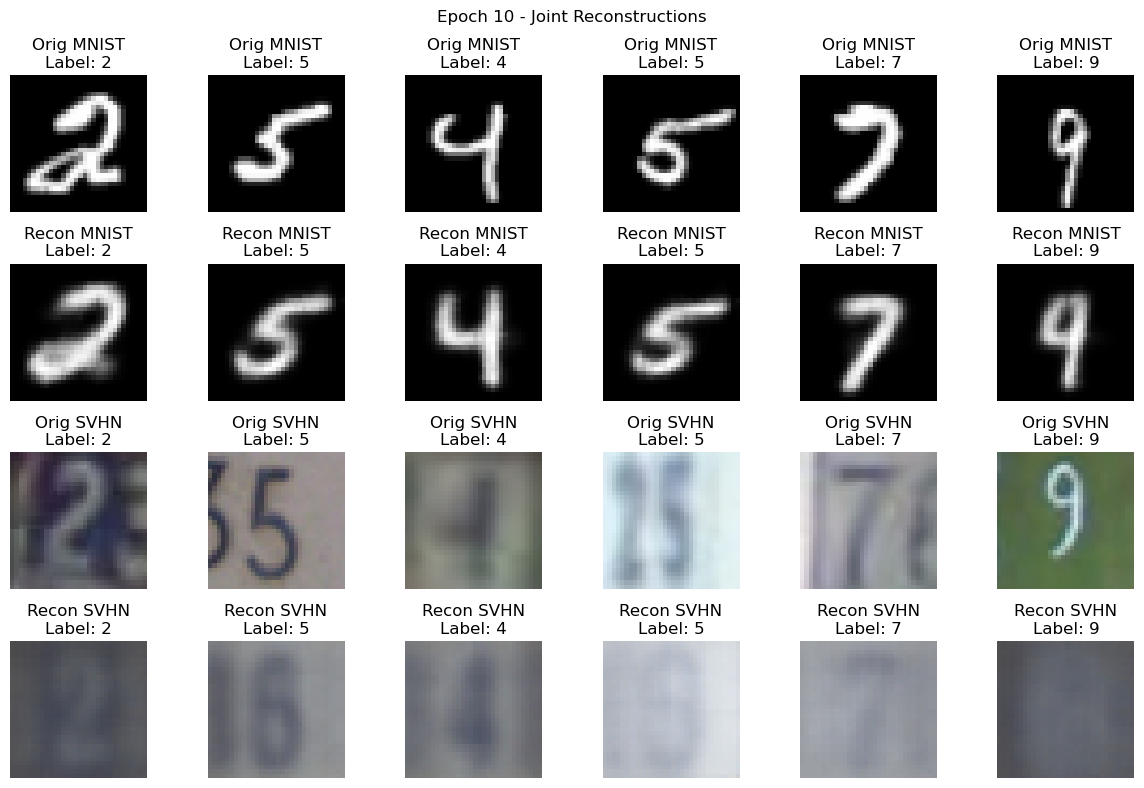

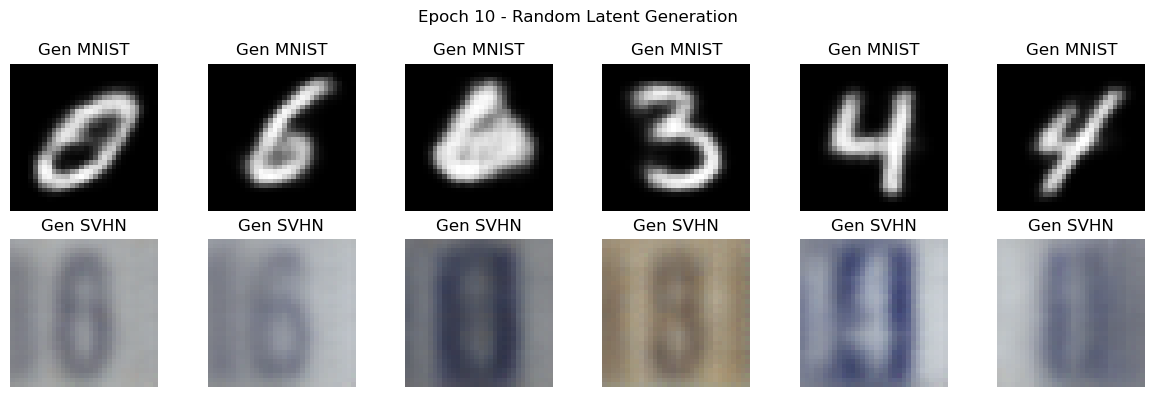

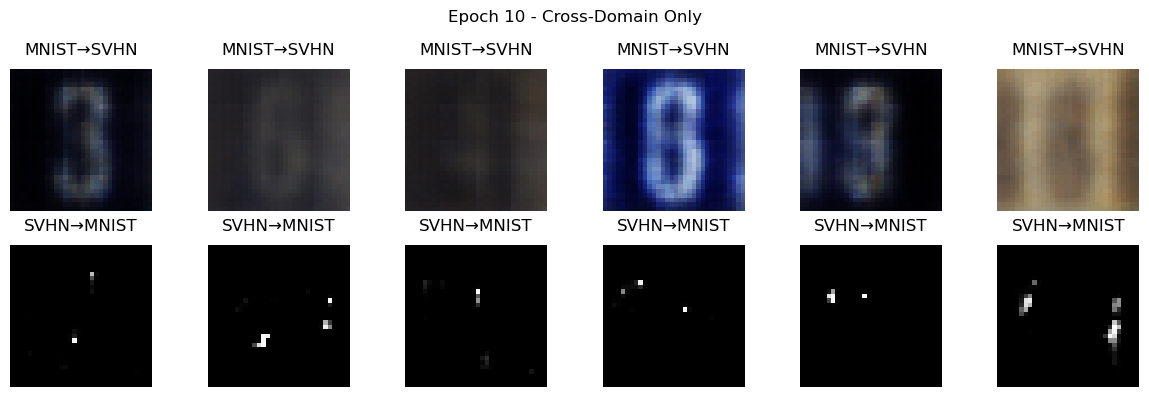

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 15
model = MultiViewVAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 11  # Number of epochs

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (mnist_batch, svhn_batch, _, _) in enumerate(paired_loader):
        mnist_batch = mnist_batch.to(device)
        svhn_batch = svhn_batch.to(device)

        optimizer.zero_grad()

        # Forward pass
        recon_mnist, recon_svhn, mu_joint, logvar_joint, _, _, _, _ = model(mnist_batch, svhn_batch)

        # Calculate loss
        loss, recon_m, recon_s, kld = vae_loss(recon_mnist, mnist_batch, recon_svhn, svhn_batch, mu_joint, logvar_joint)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(mnist_batch)}/{len(paired_loader.dataset)} '
                  f'({100. * batch_idx / len(paired_loader):.0f}%)]\tLoss: {loss.item():.6f} '
                  f'ReconM: {recon_m.item():.4f} ReconS: {recon_s.item():.4f} KLD: {kld.item():.4f}')

    avg_loss = train_loss / len(paired_loader)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')

    # Sample generation and visualization
    if epoch % 2 == 0:  # Every 2 epochs
        model.eval()
        with torch.no_grad():
            # Generate random samples from standard normal
            z_sample = torch.randn(6, latent_dim).to(device)
            x_gen_mnist, x_gen_svhn = model.generate(z_sample)
            
            # Get reconstructions from first batch
            mnist_batch, svhn_batch, mnist_batch_labels, svhn_batch_labels = next(iter(paired_loader))
            mnist_batch = mnist_batch.to(device)
            svhn_batch = svhn_batch.to(device)
            recon_m, recon_s, _, _, _, _, _, _ = model(mnist_batch, svhn_batch)

            # Cross-domain reconstruction (MNIST->SVHN and SVHN->MNIST)
            cross_mnist, cross_svhn = model.reconstruct_cross(x_mnist=mnist_batch)
            cross_svhn_to_mnist, cross_mnist_gen = model.reconstruct_cross(x_svhn=svhn_batch)
            
            # Visualize reconstructions with labels
            fig, axes = plt.subplots(4, 6, figsize=(12, 8))
            for i in range(6):
                # Original MNIST
                axes[0, i].imshow(mnist_batch[i].cpu().squeeze(), cmap='gray')
                axes[0, i].set_title(f'Orig MNIST\nLabel: {mnist_batch_labels[i]}')
                axes[0, i].axis('off')
                
                # Reconstructed MNIST
                axes[1, i].imshow(recon_m[i].cpu().squeeze(), cmap='gray')
                axes[1, i].set_title(f'Recon MNIST\nLabel: {mnist_batch_labels[i]}')
                axes[1, i].axis('off')
                
                # Original SVHN
                axes[2, i].imshow(svhn_batch[i].cpu().permute(1, 2, 0))
                axes[2, i].set_title(f'Orig SVHN\nLabel: {svhn_batch_labels[i]}')
                axes[2, i].axis('off')
                
                # Reconstructed SVHN
                axes[3, i].imshow(recon_s[i].cpu().permute(1, 2, 0))
                axes[3, i].set_title(f'Recon SVHN\nLabel: {svhn_batch_labels[i]}')
                axes[3, i].axis('off')

            plt.suptitle(f'Epoch {epoch} - Joint Reconstructions')
            plt.tight_layout()
            plt.show()
            
            # Generated samples
            fig, axes = plt.subplots(2, 6, figsize=(12, 4))
            for i in range(6):
                axes[0, i].imshow(x_gen_mnist[i].cpu().squeeze(), cmap='gray')
                axes[0, i].set_title('Gen MNIST')
                axes[0, i].axis('off')
                
                axes[1, i].imshow(x_gen_svhn[i].cpu().permute(1, 2, 0))
                axes[1, i].set_title('Gen SVHN')
                axes[1, i].axis('off')
            
            plt.suptitle(f'Epoch {epoch} - Random Latent Generation')
            plt.tight_layout()
            plt.show()

            # Cross-domain generation 
            fig, axes = plt.subplots(2, 6, figsize=(12, 4))

            for i in range(6):
                # Row 1: MNIST -> SVHN
                axes[0, i].imshow(cross_svhn[i].cpu().permute(1, 2, 0).clamp(0, 1))
                axes[0, i].set_title(f'MNIST→SVHN', pad=10)
                axes[0, i].axis('off')

                # Row 2: SVHN -> MNIST
                axes[1, i].imshow(cross_svhn_to_mnist[i].cpu().squeeze(), cmap='gray')
                axes[1, i].set_title(f'SVHN→MNIST', pad=10)
                axes[1, i].axis('off')

            plt.suptitle(f'Epoch {epoch} - Cross-Domain Only', y=0.98)
            plt.tight_layout()
            plt.show()

        model.train()

We have generated reconstructions, random latent generations, and cross-domain generations after each epoch to visualize the model's performance. The results show how well the model can reconstruct inputs from both views and generate new samples by sampling from the latent space.

Finally, we will visualize our latent space using t-SNE to see how well the model has learned to cluster the different digit classes in the shared latent space. This will help us understand how effectively the multi-view VAE has captured the underlying structure of the data across both views.

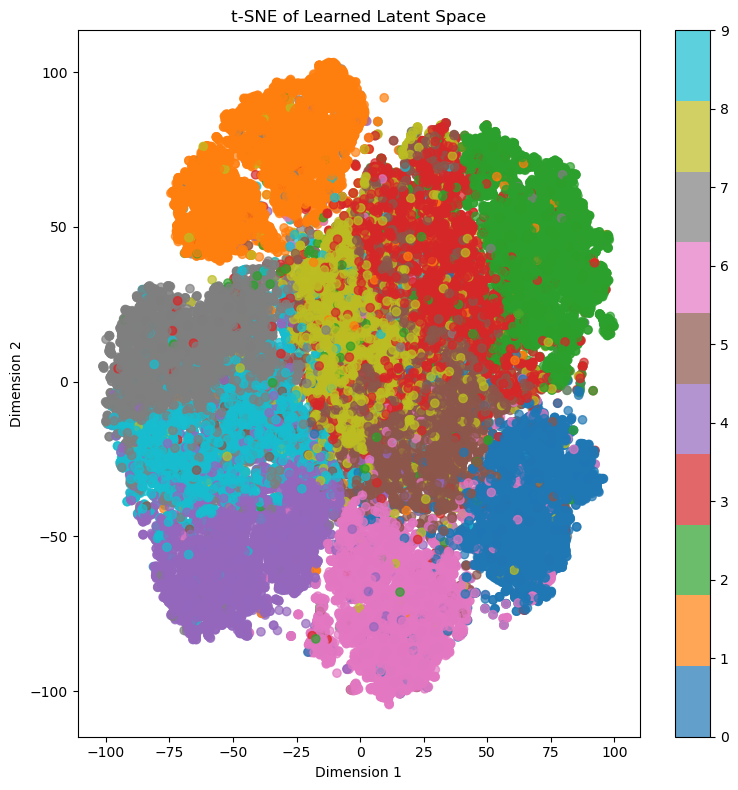

In [74]:
# Visualize learned latent space with t-SNE
from sklearn.manifold import TSNE
import warnings 
warnings.filterwarnings("ignore", category=UserWarning)

def visualize_latent_space(model, data_loader, device):
    # Extract latent representations
    model.eval()
    latents = []
    labels = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for mnist_batch, svhn_batch, mnist_labels, svhn_labels in data_loader:
            mnist_batch = mnist_batch.to(device)
            svhn_batch = svhn_batch.to(device)

            mu_joint, logvar_joint = model.encoder_mnist(mnist_batch)
            mu_svhn, logvar_svhn = model.encoder_svhn(svhn_batch)
            mu_combined, logvar_combined = product_of_experts(mu_joint, logvar_joint, mu_svhn, logvar_svhn)

            latents.append(mu_combined.cpu().numpy())
            labels.append(mnist_labels.numpy()) 

    # Concatenate all batches
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    # Plotting
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.title('t-SNE of Learned Latent Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.tight_layout()
    plt.show()

visualize_latent_space(model, paired_loader, device)